In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
mnist =tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

x_train, x_test = x_train/127.5 - 1, x_test/127.5 - 1

nb_features = np.prod(x_train.shape[1:])

x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

In [25]:
x_train.shape

(60000, 784)

### Task 1. Data visualisation (10 points)

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train)

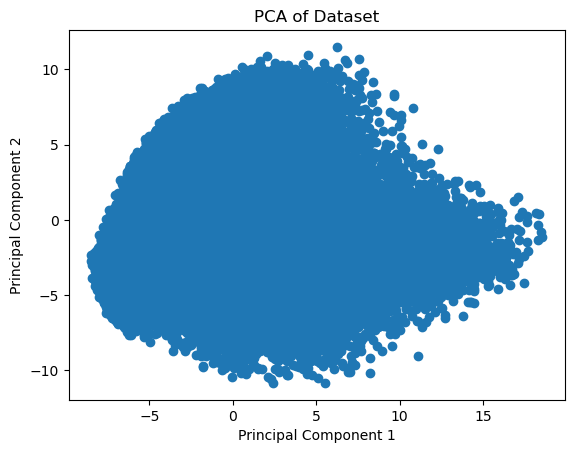

Explained variance ratio: [0.09704664 0.07095924]


In [4]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA of Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Step 4: Check explained variance ratio (how much variance is captured by each component)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

* Why is PCA a good option to visualise data?
* Add plots to your report and discuss your observations.
* Which classes can be linearly separated?


### Task 2. Perceptrons (10 points)

In [22]:
cond = (y_train==0) + (y_train==1)
binary_x_train = x_train[cond, :]
binary_y_train = y_train[cond].astype(int)
binary_y_train[binary_y_train == 0] = -1
binary_y_train[binary_y_train == 1] = 1


In [47]:
def predict(x, w, b):
    weighted_sum = np.dot(x, w)
    result = 1 if weighted_sum > b else -1

    return result

def optimize(x, y):
    iteration = 0
    error = np.inf
    m, n = x.shape
    w = np.random.uniform(-1, 1, n)
    b = np.random.uniform(-1, 1)
    learning_rate = 0.002
    while (iteration <= 30) & (error > 1e-3):
        error = 0
        fp, fn = 0, 0
        for sample, target in zip(x, y):
            prediction = predict(sample, w, b)
            if prediction != target:
                if prediction > target:
                    fp += 1
                else:
                    fn += 1
                error = error + 1
                w = w + learning_rate*(target-prediction)*sample
                b = b + learning_rate*(target-prediction)

        iteration += 1        
        print("Iteration:", iteration, 'with error:', error, fp, fn)


optimize(binary_x_train, binary_y_train)

Iteration: 1 with error: 215 110 105
Iteration: 2 with error: 44 22 22
Iteration: 3 with error: 36 18 18
Iteration: 4 with error: 31 15 16
Iteration: 5 with error: 24 12 12
Iteration: 6 with error: 22 11 11
Iteration: 7 with error: 22 11 11
Iteration: 8 with error: 18 9 9
Iteration: 9 with error: 23 11 12
Iteration: 10 with error: 21 11 10
Iteration: 11 with error: 17 8 9
Iteration: 12 with error: 18 9 9
Iteration: 13 with error: 16 8 8
Iteration: 14 with error: 16 8 8
Iteration: 15 with error: 17 8 9
Iteration: 16 with error: 14 7 7
Iteration: 17 with error: 12 6 6
Iteration: 18 with error: 14 7 7
Iteration: 19 with error: 12 6 6
Iteration: 20 with error: 8 4 4
Iteration: 21 with error: 12 6 6
Iteration: 22 with error: 10 5 5
Iteration: 23 with error: 6 3 3
Iteration: 24 with error: 10 5 5
Iteration: 25 with error: 6 3 3
Iteration: 26 with error: 8 4 4
Iteration: 27 with error: 6 3 3
Iteration: 28 with error: 6 3 3
Iteration: 29 with error: 8 4 4
Iteration: 30 with error: 6 3 3
Iterat

In [187]:
digit = binary_x_train[8].reshape(28, 28)

In [197]:
binary_y_train[:6]

array([-1,  1,  1,  1,  1, -1])

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def print_digit(sample_no):
    digit = sample_no.reshape(28, 28)

    plt.imshow(digit, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Hide the axes
    plt.show()

In [33]:
sorted_labels = np.argsort(y_train)
x_train_sorted = x_train[sorted_labels]

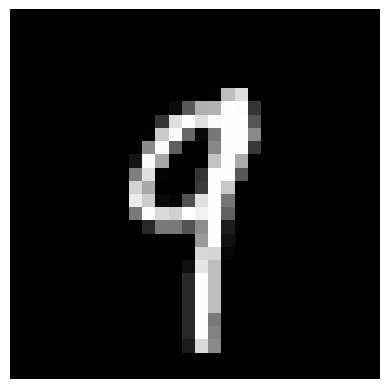

In [49]:
print_digit(x_train_sorted[59999])